In [1]:
import cmocean as cmo
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from xmitgcm import open_mdsdataset

In [3]:
sshData = xr.open_dataset('../curtain_SSH_SVB_febTS.nc')
sshData_noSVB = xr.open_dataset('../curtain_SSH_NoSVB_febTS.nc')

outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/01_noSVB_febTS/'
levels = [0, 1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 
          73, 78, 83, 88, 93, 98]
iters = [5000]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], iters=iters, levels=levels)
ds2 = open_mdsdataset(outdir2, prefix=['eta','dynVars'], iters=iters, levels=levels)

In [4]:
sns.set_style('ticks')
sns.set_context('paper')
cmap=cmo.cm.curl

In [8]:
depth_nob = ds2.Depth[:]
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360
Zl = ds2['Zl'][:]

times = np.arange(720)*600

# centers mask
hFacC = ds2['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth_nob,0)
mask_dep = np.ma.getmask(dep_masked)

# depth bathy with bay
depth_bay = ds.Depth[:]

In [13]:
def get_snapshot_at_level(ds,tt,zz,fld):
    W = ds[fld][tt,zz,:,:]
    return(W)

def get_snapshot_eta(ds,tt):
    Eta = ds['ETAN'][tt,:,:]
    return(Eta)

def plot_field_w(ax,tt,lon,lat,fld,mask,zind,title,
                 cmap=cmo.cm.balance,vmin=-0.3, vmax=0.3, cb=1):
    ax.set_facecolor('tan')
    cmap.set_over("lavender")
    cmap.set_under("lavender")
    levels = np.linspace(vmin,vmax,30)
    pc = ax.pcolormesh(lon,lat, 
                       np.ma.masked_array(fld,mask=mask[zind,:,:]),
                       cmap=cmap, norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False))
    ax.contour(lon,lat,depth_nob, levels=[0], color='k')
    ax.contour(lon,lat,depth_bay, levels=[0], color='k')
    ax.contour(lon,lat,depth_bay, levels=[500], color='0.5', alpha=0.5)
     
    if cb==1:
        cbar_ax = fig.add_axes([0.114, 0.06, 0.25, 0.01])
        cb = fig.colorbar(pc, 
                          cax=cbar_ax,
                          orientation='horizontal', 
                          format='%1.0f', extend='both', label='SSH ($10^{-4}$ m)', 
                          ticks=[-2,-1,0,1,2])
        cb.ax.xaxis.set_label_position("bottom")
    elif cb==4:
        cbar_ax = fig.add_axes([0.388, 0.06, 0.25, 0.01])
        cb = fig.colorbar(pc, 
                          cax=cbar_ax,
                          orientation='horizontal', 
                          format='%1.1f',extend='both', label='$v$ (mm$~$s$^{-1}$)', 
                          ticks=[-1.4,-0.7,0,0.7,1.4])
        cb.ax.xaxis.set_label_position("bottom")
    else:
         cbar_ax = fig.add_axes([0.663, 0.06, 0.25, 0.01])
         cb = fig.colorbar(pc, 
                           cax=cbar_ax,
                           orientation='horizontal', 
                           format='%1.0f',extend='both', label='$w$ ($10^{-6}$ m$~$s$^{-1}$)',
                           ticks=[-8,-6,-4,-2,0,2,4,6,8])
         cb.ax.xaxis.set_label_position("bottom")
    
    ax.text(0.45,0.9, title, transform=ax.transAxes)
    ax.set_aspect(1)
    return(ax)
    
def make_fig(tt):
    Eta_bay = get_snapshot_eta(ds, tt)
    Eta_nb = get_snapshot_eta(ds2, tt)
    Wbay = get_snapshot_at_level(ds, tt, zz2, 'WVEL')
    Wnb = get_snapshot_at_level(ds2, tt, zz2, 'WVEL')
    Vbay = get_snapshot_at_level(ds, tt, zz, 'VVEL')
    Vnb = get_snapshot_at_level(ds2, tt, zz, 'VVEL')
   
     
    axx5 = plot_field_w(ax5,tt,lon,lat,(Eta_bay-Eta_nb)*10000,
                      mask,zz,
                      'surface',cmap=cmo.cm.curl, vmin=-2, vmax=2, cb=1)
    axx6 = plot_field_w(ax6,tt,lon,lat,(Vbay-Vnb)*1000,
                        mask,zz,
                        'surface',
                         cmap=cmo.cm.balance, vmin=-1.4, vmax=1.4, cb=4)
    axx7 = plot_field_w(ax7,tt,lon,lat,(Wbay-Wnb)*1E6,
                        mask,zz2,
                        r'%1.0f m depth' %(-Zl[zz2]),
                        cmap=cmo.cm.balance, vmin=-8, vmax=8, cb=2)
   
    ax5.set_ylabel('Lat')
    ax5.set_xlabel('Lon')
    ax6.set_xlabel('Lon')
    ax7.set_xlabel('Lon')
    ax5.set_xlim(-121.5,-114)
    ax6.set_xlim(-121.5,-114)
    ax7.set_xlim(-121.5,-114)

    ax5.text(0.05,0.05, '(e)', transform=ax5.transAxes, fontweight='bold')
    ax6.text(0.05,0.05, '(f)', transform=ax6.transAxes, fontweight='bold')
    ax7.text(0.05,0.05, '(g)', transform=ax7.transAxes, fontweight='bold')

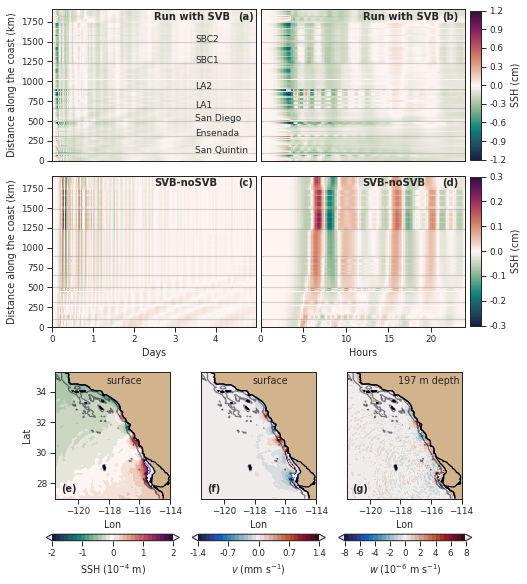

In [14]:
## === FIGURE ===
fig = plt.figure(figsize=(7.4,9))
gs0 = gridspec.GridSpec(2, 1, height_ratios=[1,0.4], hspace=0.2)
gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0], wspace=0.02, hspace=0.1 ) # SSH hovmollers
gs01 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1]) # CTW

ax1 = plt.subplot(gs00[0,0]) 
ax2 = plt.subplot(gs00[0,1])
ax3 = plt.subplot(gs00[1,0])
ax4 = plt.subplot(gs00[1,1])
ax5 = plt.subplot(gs01[0])
ax6 = plt.subplot(gs01[1])
ax7 = plt.subplot(gs01[2])


# Full run (SVB)
pc = ax1.pcolormesh(sshData.T/(24*3600), 
                   sshData.X,
                   np.transpose((sshData.curtain_data.data)*100),
                   vmin=-1.2, vmax=1.2, cmap=cmap)

pc2 = ax2.pcolormesh(sshData.T/(3600), 
                   sshData.X,
                   np.transpose((sshData.curtain_data.data)*100),
                   vmin=-1.2, vmax=1.2, cmap=cmap)
cbar_ax2 = fig.add_axes([0.91, 0.648, 0.02, 0.23])
cb = fig.colorbar(pc, cax=cbar_ax2, 
                  format='%1.1f', label='SSH (cm)',
                  ticks=[-1.2,-0.9,-0.6,-0.3,0,0.3,0.6,0.9,1.2])
ax2.set_xlim(0,24)

# Bay-No Bay
pc3 = ax3.pcolormesh(sshData.T/(24*3600), 
                   sshData.X,
                   np.transpose((sshData.curtain_data.data-
                                 sshData_noSVB.curtain_data.data)*100),
                   vmin=-0.3, vmax=0.3, cmap=cmap)

pc4 = ax4.pcolormesh(sshData.T/(3600), 
                sshData.X,
                np.transpose((sshData.curtain_data.data-
                              sshData_noSVB.curtain_data.data)*100),
                   vmin=-0.3, vmax=0.3, cmap=cmap)
cbar_ax4 = fig.add_axes([0.91, 0.392, 0.02, 0.23])
cb4 = fig.colorbar(pc4, cax=cbar_ax4, 
                  format='%1.1f', label='SSH (cm)',
                  ticks=[-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
ax4.set_xlim(0,24)

# Reference lines
for km, lab in zip([101,313.7,500, 660, 900, 1231, 1492], ['San Quintin','Ensenada','San Diego','LA1','LA2','SBC1', 'SBC2']):
    ax1.axhline(km,color='0.5',alpha=0.3)
    ax1.text(3.5,km,lab, fontsize=9)
    ax2.axhline(km,color='0.5',alpha=0.3)
    
    ax3.axhline(km,color='0.5',alpha=0.3)
    ax4.axhline(km,color='0.5',alpha=0.3)

# Labels, etc
ax1.set_ylabel('Distance along the coast (km)')
ax3.set_ylabel('Distance along the coast (km)')
ax3.set_xlabel('Days')
ax4.set_xlabel('Hours')

ax1.set_xticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax4.set_yticks([])

ax1.text(0.91,0.93,'(a)',fontweight='bold', fontsize=10, transform=ax1.transAxes)
ax2.text(0.89,0.93,'(b)',fontweight='bold', fontsize=10, transform=ax2.transAxes)
ax3.text(0.91,0.93,'(c)',fontweight='bold', fontsize=10, transform=ax3.transAxes)
ax4.text(0.89,0.93,'(d)',fontweight='bold', fontsize=10, transform=ax4.transAxes)

ax1.text(0.5,0.93,'Run with SVB',fontweight='bold', fontsize=10, transform=ax1.transAxes)
ax2.text(0.5,0.93,'Run with SVB',fontweight='bold', fontsize=10, transform=ax2.transAxes)
ax3.text(0.5,0.93,'SVB-noSVB',fontweight='bold', fontsize=10, transform=ax3.transAxes)
ax4.text(0.5,0.93,'SVB-noSVB',fontweight='bold', fontsize=10, transform=ax4.transAxes)

#----------- CTW fig -------------------
zz = 0
zz2 = 38
tt = 0 # corresponds to iter 5000

for ax in [ax6,ax7]:
    ax.set_yticks([])
    
make_fig(tt)  

# --- save figure ----
#plt.savefig('figure03.png', dpi=500, bbox_inches='tight')